In [10]:
# Cell 1
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# File paths (adjust if needed)
paths = {
    'Iodine': "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/iodine/all_pcaps_allN.csv",
    'DNS2TCP': "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dns2tcp/all_pcaps_allN.csv",
    'DNScat2': "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dnscat2/all_pcaps_allN.csv",

    'DGA_Google': "/home/ubuntu/DoH_DGA_training/datasets/DGA_Google/all_pcaps_allN.csv",
    'DGA_Cloudflare': "/home/ubuntu/DoH_DGA_training/datasets/DGA_CF/all_pcaps_allN.csv",
    'DGA_AdGuard': "/home/ubuntu/DoH_DGA_training/datasets/DGA_ADGuard/all_pcaps_allN.csv",
    'DGA_Quad9': "/home/ubuntu/DoH_DGA_training/datasets/DGA_Quad9/all_pcaps_allN.csv",
    'DGA_HKD': "/home/ubuntu/DoH_DGA_training/datasets/DGA_HKD/all_pcaps_allN.csv",

    'DoH_Benign': "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_doh.csv",
    'NonDoH_Benign': "/home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHBenign-NonDoH/all_nondoh.csv",
}


In [11]:
# Cell 2 (updated): load csvs, filter by N_value, drop 'N' and unwanted cols, assign labels
N_value = 16   # <-- change this to 8, 16, 32, 64 as needed

# paths dict should already exist from Cell 1
dfs = {}
counts = {}

for label, p in paths.items():
    if not os.path.exists(p):
        raise FileNotFoundError(f"Missing file for {label}: {p}")
    df = pd.read_csv(p)

    # If the file contains an 'N' column, filter rows with the requested N_value
    if "N" in df.columns:
        df = df[df["N"] == N_value].copy()
        # drop the N column after filtering
        df.drop(columns=["N"], inplace=True, errors="ignore")
    else:
        # no N column -> keep whole file but notify
        print(f"Warning: file for {label} has no 'N' column; keeping all rows from {p}")

    # Drop any extra metadata columns we don't want as features (optional)
    df.drop(columns=['pcap_file', 'source_pcap'], inplace=True, errors="ignore")

    # assign the fine-grained label (one label per source dataset)
    df['label'] = label
    dfs[label] = df
    counts[label] = df.shape[0]
    print(f"Loaded {label}: {p} -> {df.shape[0]} rows after filtering N={N_value}")

# Combine all datasets
df_all = pd.concat(list(dfs.values()), ignore_index=True)
print("\nPer-source counts after filtering:")
for k, v in counts.items():
    print(f"  {k}: {v}")
print("\nCombined shape:", df_all.shape)
print("Per-class counts:\n", df_all['label'].value_counts())


Loaded Iodine: /home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/iodine/all_pcaps_allN.csv -> 12355 rows after filtering N=16
Loaded DNS2TCP: /home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dns2tcp/all_pcaps_allN.csv -> 153025 rows after filtering N=16
Loaded DNScat2: /home/ubuntu/DoH_DGA_training/datasets/PCAPs/DoHMalicious/dnscat2/all_pcaps_allN.csv -> 10289 rows after filtering N=16
Loaded DGA_Google: /home/ubuntu/DoH_DGA_training/datasets/DGA_Google/all_pcaps_allN.csv -> 25439 rows after filtering N=16
Loaded DGA_Cloudflare: /home/ubuntu/DoH_DGA_training/datasets/DGA_CF/all_pcaps_allN.csv -> 25418 rows after filtering N=16
Loaded DGA_AdGuard: /home/ubuntu/DoH_DGA_training/datasets/DGA_ADGuard/all_pcaps_allN.csv -> 25427 rows after filtering N=16
Loaded DGA_Quad9: /home/ubuntu/DoH_DGA_training/datasets/DGA_Quad9/all_pcaps_allN.csv -> 25418 rows after filtering N=16
Loaded DGA_HKD: /home/ubuntu/DoH_DGA_training/datasets/DGA_HKD/all_pcaps_allN.csv -> 2253 rows after 

In [12]:
# Cell 3 (updated): restrict to the exact 16 features (in the requested order)

# Desired feature list (exact order)
desired_features = [
    "client_pkt_max",
    "n_client",
    "bytes_fraction_client",
    "n_server",
    "pkt_fraction_client",
    "client_bytes",
    "server_pkt_max",
    "size_min",
    "size_mean",
    "server_pkt_mean",
    "dir_switches",
    "server_bytes",
    "size_max",
    "client_pkt_min",
    "server_pkt_min",
    "client_pkt_mean"
]

# Check presence in df_all
present = [f for f in desired_features if f in df_all.columns]
missing = [f for f in desired_features if f not in df_all.columns]

if missing:
    print("Warning: the following desired features are MISSING from df_all:")
    for m in missing:
        print("  -", m)
    print("Proceeding with the subset of present features.\n")

# Select only the present desired features, preserving order
feature_cols = [f for f in desired_features if f in present]

print(f"Using {len(feature_cols)} feature(s): {feature_cols}")

# Drop rows where any of the selected features or label is NaN
df_all = df_all.dropna(subset=feature_cols + ['label']).reset_index(drop=True)

# Coerce to numeric (in-place) and drop rows that become NaN after coercion
for c in feature_cols:
    if not np.issubdtype(df_all[c].dtype, np.number):
        df_all[c] = pd.to_numeric(df_all[c], errors='coerce')
df_all = df_all.dropna(subset=feature_cols + ['label']).reset_index(drop=True)

# Final feature matrix and target (keep feature order)
X = df_all[feature_cols].astype(float)
y = df_all['label'].astype(str)

print("Final X shape:", X.shape, "y shape:", y.shape)
print("Label distribution:\n", y.value_counts())

# Optional: show a quick check of the feature ranges (first few rows)
display(df_all[feature_cols].head())


Using 16 feature(s): ['client_pkt_max', 'n_client', 'bytes_fraction_client', 'n_server', 'pkt_fraction_client', 'client_bytes', 'server_pkt_max', 'size_min', 'size_mean', 'server_pkt_mean', 'dir_switches', 'server_bytes', 'size_max', 'client_pkt_min', 'server_pkt_min', 'client_pkt_mean']


Final X shape: (843528, 16) y shape: (843528,)
Label distribution:
 label
NonDoH_Benign     534801
DNS2TCP           153025
DoH_Benign         29103
DGA_Google         25439
DGA_AdGuard        25427
DGA_Cloudflare     25418
DGA_Quad9          25418
Iodine             12355
DNScat2            10289
DGA_HKD             2253
Name: count, dtype: int64


,client_pkt_max,n_client,bytes_fraction_client,n_server,pkt_fraction_client,client_bytes,server_pkt_max,size_min,size_mean,server_pkt_mean,dir_switches,server_bytes,size_max,client_pkt_min,server_pkt_min,client_pkt_mean
0,119.0,7.0,0.395911,9.0,0.4375,639.0,266.0,26.0,100.8750,108.333333,6.0,975.0,266.0,26.0,26.0,91.285714
1,151.0,8.0,0.394478,8.0,0.5000,843.0,250.0,26.0,133.5625,161.750000,13.0,1294.0,250.0,26.0,47.0,105.375000
2,142.0,7.0,0.373716,9.0,0.4375,691.0,285.0,26.0,115.5625,128.666667,10.0,1158.0,285.0,26.0,26.0,98.714286
3,122.0,6.0,0.312747,10.0,0.3750,395.0,358.0,26.0,78.9375,86.800000,4.0,868.0,358.0,26.0,26.0,65.833333
4,185.0,6.0,0.309769,10.0,0.3750,482.0,358.0,26.0,97.2500,107.400000,6.0,1074.0,358.0,26.0,26.0,80.333333


In [13]:
# Cell 4
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes (dataset-specific):", list(le.classes_))

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Train/test sizes:", X_train.shape, X_test.shape)


Classes (dataset-specific): ['DGA_AdGuard', 'DGA_Cloudflare', 'DGA_Google', 'DGA_HKD', 'DGA_Quad9', 'DNS2TCP', 'DNScat2', 'DoH_Benign', 'Iodine', 'NonDoH_Benign']
Train/test sizes: (674822, 16) (168706, 16)


In [14]:
# Cell 5
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),   # a bit larger for multi-class
    activation="relu",
    solver="adam",
    alpha=1e-4,
    batch_size=64,
    learning_rate="adaptive",
    learning_rate_init=0.001,
    max_iter=20,
    shuffle=True,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled, y_train)


Iteration 1, loss = 0.10171099
Validation score: 0.984841
Iteration 2, loss = 0.04886996
Validation score: 0.988353
Iteration 3, loss = 0.04044324
Validation score: 0.984529
Iteration 4, loss = 0.03620202
Validation score: 0.991568
Iteration 5, loss = 0.03300058
Validation score: 0.987464
Iteration 6, loss = 0.03073276
Validation score: 0.989049
Iteration 7, loss = 0.02922588
Validation score: 0.993584
Iteration 8, loss = 0.02793998
Validation score: 0.992769
Iteration 9, loss = 0.02727262
Validation score: 0.993672
Iteration 10, loss = 0.02574822
Validation score: 0.988812
Iteration 11, loss = 0.02476796
Validation score: 0.993821
Iteration 12, loss = 0.02464112
Validation score: 0.993480
Iteration 13, loss = 0.02353909
Validation score: 0.994947
Iteration 14, loss = 0.02339377
Validation score: 0.989731
Iteration 15, loss = 0.02202858
Validation score: 0.995051
Iteration 16, loss = 0.02044413
Validation score: 0.995451
Iteration 17, loss = 0.01987734
Validation score: 0.995495
Iterat

/home/ubuntu/miniconda/envs/jupyterenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


,hidden_layer_sizes,"(128, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,64
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,20
,shuffle,True
,random_state,42


Classification report (dataset-specific classes):

                precision    recall  f1-score   support

   DGA_AdGuard     0.9998    0.9992    0.9995      5085
DGA_Cloudflare     0.9992    0.9998    0.9995      5084
    DGA_Google     0.9998    0.9988    0.9993      5088
       DGA_HKD     0.9977    0.9778    0.9877       450
     DGA_Quad9     0.9992    0.9996    0.9994      5084
       DNS2TCP     0.9967    0.9956    0.9961     30605
       DNScat2     0.9205    0.9509    0.9355      2058
    DoH_Benign     0.9756    0.9883    0.9819      5821
        Iodine     0.9267    0.9061    0.9163      2471
 NonDoH_Benign     0.9987    0.9983    0.9985    106960

      accuracy                         0.9956    168706
     macro avg     0.9814    0.9814    0.9814    168706
  weighted avg     0.9956    0.9956    0.9956    168706



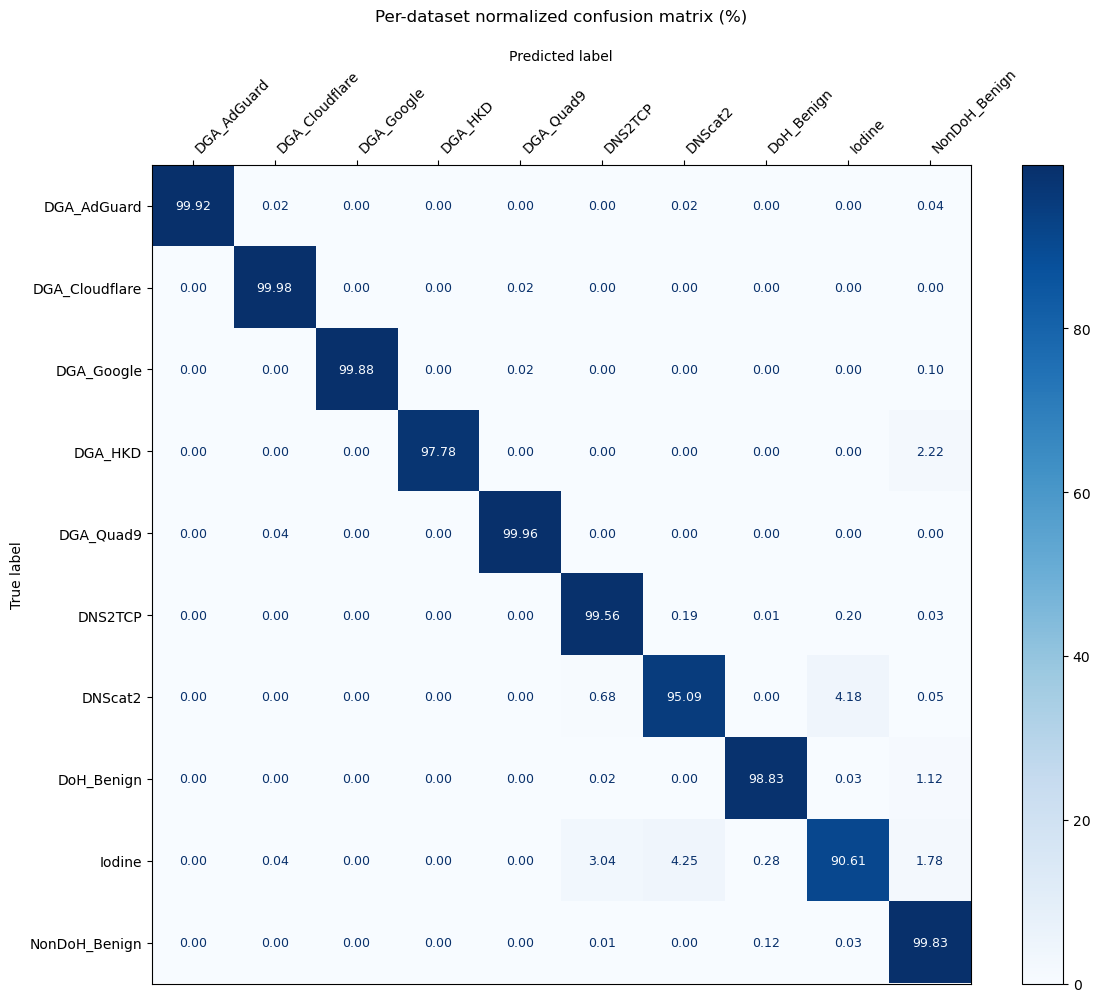

In [15]:
# Cell 6
y_pred = mlp.predict(X_test_scaled)

print("Classification report (dataset-specific classes):\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# Confusion matrix (normalized by true class -> recall per dataset)
cm = confusion_matrix(y_test, y_pred, normalize='true') * 100
fig, ax = plt.subplots(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format=".2f")
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=45, ha='left', fontsize=10)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)
for t in ax.texts: t.set_fontsize(9)
plt.title("Per-dataset normalized confusion matrix (%)", pad=20)
plt.tight_layout()
plt.show()


In [ ]:
# Cell 7: map fine classes -> coarse groups
coarse_map = {}
for cls in le.classes_:
    if cls.startswith('DGA_'):
        coarse_map[cls] = 'DGA'
    elif cls in ('Iodine', 'DNS2TCP', 'DNScat2'):
        coarse_map[cls] = 'DoH_Tunnel'
    elif cls == 'DoH_Benign':
        coarse_map[cls] = 'DoH_Benign'
    elif cls == 'NonDoH_Benign':
        coarse_map[cls] = 'NonDoH_Benign'
    else:
        coarse_map[cls] = 'Other'

# build coarse labels for test and predictions
inv_label = {i: cls for i, cls in enumerate(le.classes_)}
y_test_fine = [inv_label[i] for i in y_test]
y_pred_fine = [inv_label[i] for i in y_pred]

y_test_coarse = [coarse_map[f] for f in y_test_fine]
y_pred_coarse = [coarse_map[f] for f in y_pred_fine]

# compute recall per coarse class
from sklearn.metrics import recall_score
coarse_le = LabelEncoder()
y_test_coarse_enc = coarse_le.fit_transform(y_test_coarse)
y_pred_coarse_enc = coarse_le.transform(y_pred_coarse)
print("Coarse classes:", list(coarse_le.classes_))
print("Coarse recall (per-class):")
for i, cls in enumerate(coarse_le.classes_):
    mask = (y_test_coarse_enc == i)
    if mask.sum() == 0:
        print(f"{cls}: no samples in test")
        continue
    rec = recall_score(y_test_coarse_enc, y_pred_coarse_enc, labels=[i], average='macro')
    print(f"{cls}: {rec:.4f}")
